In [8]:
import os
import pydicom
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy

Load original CT

In [9]:
SLICE_FOLDER = '../data/RadCTTACEomics_1685/1685/10_AP_Ax2.50mm/'

# load dicom slice files
slices = [pydicom.dcmread(os.path.join(SLICE_FOLDER, f)) 
          for f in os.listdir(SLICE_FOLDER) if f.endswith('.dcm')]

# sort slices by SliceLocation (or InstanceNumber)
slices.sort(key=lambda x: int(x.SliceLocation))

# Stack into 3D volume
img_dcm = np.stack([s.pixel_array for s in slices], axis=0)

img_dcm.shape

(86, 512, 512)

Load segmentation mask

In [10]:
segm_ds = pydicom.dcmread('../data/RadCTTACEomics_1685/1685/10_AP_Ax2.50mm_ManualROI_Tumor.dcm')

tumor = np.zeros_like(img_dcm)

for i, frame in enumerate(segm_ds.PerFrameFunctionalGroupsSequence):
    # print(int(frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedFrameNumber))
    # copy the tumor slice into the same shaped tumor matrix to rotate
    index = int(frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedFrameNumber)
    tumor[index - 1, ...] = np.where(segm_ds.pixel_array[i, ...] == 1, img_dcm[index - 1, ...], 0)

Define MIP and rotation functions

In [11]:
def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)

def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)

def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

MovieWriter ffmpeg unavailable; using Pillow instead.


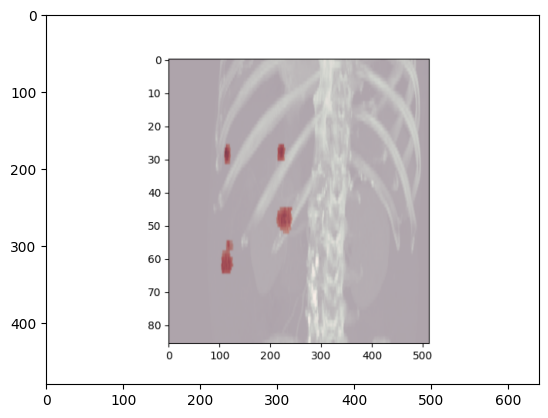

In [ ]:
pixel_len_mm = [float(slices[0].SliceThickness), float(slices[0].PixelSpacing[0]), slices[0].PixelSpacing[1]]

# Create projections varying the angle of rotation
#   Configure visualization colormap
img_min = np.amin(img_dcm)
img_max = np.amax(img_dcm)

mask_min = np.amin(tumor)
mask_max = np.amax(tumor)

cm = matplotlib.colormaps['bone']
fig, ax = plt.subplots()
#   Configure directory to save results
os.makedirs('results/MIP/', exist_ok=True)
#   Create projections
n = 6
for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    #ax.clear()

    # Rotate and show the original CT image
    rotated_img = rotate_on_axial_plane(img_dcm, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    
    # Rotate and show the tumor mask
    rotated_mask = rotate_on_axial_plane(tumor, alpha)
    projection_mask = MIP_sagittal_plane(rotated_mask)
    
    # Plot the CT image
    plt.imshow(projection, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])

    # Overlay the tumor mask
    # plt.imshow(np.ma.masked_where(projection_mask == 0, projection), cmap='Set1', alpha=0.5, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.imshow(projection_mask, cmap='Reds', alpha=0.5, vmin=mask_min, vmax=mask_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])

    # Save the combined projection
    plt.savefig(f'results/MIP/Projection_{idx}.png')


In [19]:
!pip install imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 5.6 MB/s eta 0:00:006.6 MB/s eta 0:00:01


In [21]:
import imageio

# Define the directory containing the PNG images
image_folder = 'results/MIP/'

# Get the list of PNG files in the folder
png_files = [os.path.join(image_folder, f'Projection_{idx}.png') for idx in range(n)]

# Create a GIF from the PNG files
gif_path = 'results/MIP/Projections.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.25, loop=0) as writer:
    for png_file in png_files:
        image = imageio.imread(png_file)
        writer.append_data(image)

print(f"GIF saved at {gif_path}")

GIF saved at results/MIP/Projections.gif


/tmp/ipykernel_13963/3637838589.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(png_file)
